<a href="https://colab.research.google.com/github/Jyo172/New-Rep/blob/master/Adclicks_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files, drive
drive.mount('gdrive', force_remount=True)

Mounted at gdrive


In [2]:
!cp 'gdrive/My Drive/ad_clicks.zip' .
!unzip ad_clicks.zip

Archive:  ad_clicks.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from datetime import *
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
train_df = pd.read_csv('train.csv')

In [6]:
train_df.shape

(12137810, 10)

In [7]:
#Since the data is huge in size,10% of the data is sampled
sample_df = train_df.sample(frac=0.1, random_state = 42)
sample_df.head()

,ID,datetime,siteid,offerid,category,merchant,countrycode,browserid,devid,click
5236822,IDybLltC5,2017-01-11 10:18:32,9759547.0,525348,42227,21153737,a,NaN,Desktop,0
10696411,ID9MnifkN,2017-01-16 08:32:07,NaN,921107,904,58604466,b,Edge,Tablet,0
1823835,IDYcLRLqB,2017-01-12 10:35:50,7974132.0,707989,42227,1436904,a,Edge,Tablet,0
3295561,ID7tTKae3,2017-01-14 07:08:56,7614195.0,216666,42227,43770446,a,Mozilla,Desktop,0
6584561,IDfP3DBd0,2017-01-12 07:43:49,3428619.0,564123,50088,57977218,d,Firefox,Mobile,0


In [8]:
sample_df.shape

(1213781, 10)

In [9]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1213781 entries, 5236822 to 9230606
Data columns (total 10 columns):
ID             1213781 non-null object
datetime       1213781 non-null object
siteid         1092678 non-null float64
offerid        1213781 non-null int64
category       1213781 non-null int64
merchant       1213781 non-null int64
countrycode    1213781 non-null object
browserid      1152641 non-null object
devid          1031895 non-null object
click          1213781 non-null int64
dtypes: float64(1), int64(4), object(5)
memory usage: 101.9+ MB


In [10]:
#We have to deal with categorical variables and missing values
total = sample_df.isnull().sum(axis=0).sort_values(ascending=False)
percent = ((sample_df.isnull().sum(axis=0)/sample_df.isnull().count(axis=0))*100).sort_values(ascending=False)
missing_data_columns = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data_columns.head(10)

,Total,Percent
devid,181886,14.985076
siteid,121103,9.977335
browserid,61140,5.037153
click,0,0.000000
countrycode,0,0.000000
merchant,0,0.000000
category,0,0.000000
offerid,0,0.000000
datetime,0,0.000000
ID,0,0.000000


In [0]:
#since percentage is not large we can fill Nan with mode values
sample_df['siteid'].fillna(train_df['siteid'].mode()[0],inplace=True)
sample_df['browserid'].fillna(train_df['browserid'].mode()[0],inplace=True)
sample_df['devid'].fillna(train_df['devid'].mode()[0],inplace=True)

In [0]:
#working with datetime column;extracting date,day and hour
def hr_func(ts):
  return ts.hour
sample_df['datetime']=pd.to_datetime(sample_df['datetime'])
sample_df['date'] = sample_df['datetime'].dt.date
dic={'2017-01-10':'Tues','2017-01-11':'Wed','2017-01-12':'Thrus','2017-01-13':'Fri','2017-01-14':'Sat','2017-01-15':'Sun','2017-01-16':'Mon','2017-01-17':'Tues','2017-01-18':'Wed','2017-01-19':'Thrus','2017-01-20':'Fri'}
sample_df['day']=sample_df['date'].astype(str).map(dic)
sample_df['hour']=sample_df['datetime'].apply(hr_func)

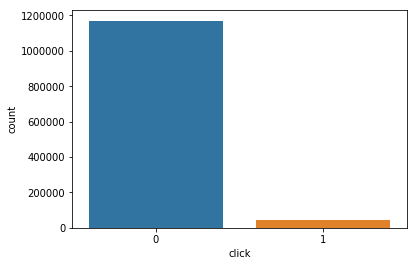

In [13]:
#looking at the target:click infering that there's high class imbalance
sns.countplot(sample_df['click'])

Text(0.5, 1.0, 'Dependency of browserid with Target')

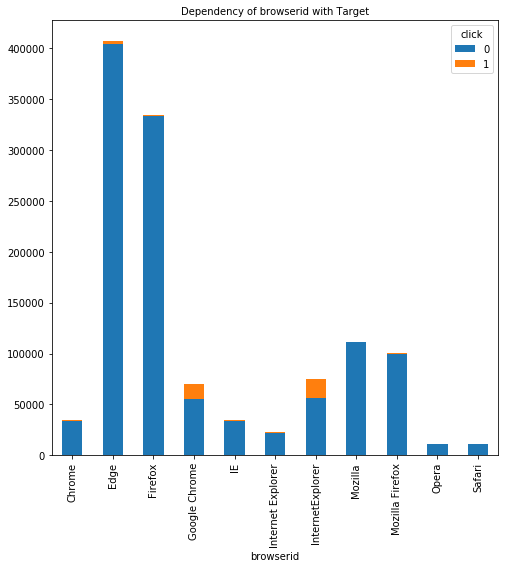

In [14]:
# analysis of browserid,it is observed that some of the categories are repeated
brcl=pd.crosstab(sample_df['browserid'],sample_df['click'])
brcl.plot(kind="bar",figsize=(8,8),stacked=True)
plt.title('Dependency of browserid with Target', fontsize = 10)

In [15]:
#Removing redundant info
c = {'Internet Explorer':"IntEx", 'IE':"IntEx", 'InternetExplorer':"IntEx", 'Chrome': "GoogC", 'Google Chrome': "GoogC",'Mozilla Firefox':"MF", 'Mozilla': "MF", 'Firefox': "MF", 'Opera': "Opera", 'Safari':"Safari", 'Edge':"Edge"}
sample_df['browserid_1']=sample_df['browserid'].map(c)
sample_df['browserid_1'].value_counts()

MF        547008
Edge      406994
IntEx     132330
GoogC     104615
Safari     11439
Opera      11395
Name: browserid_1, dtype: int64

Text(0.5, 1.0, 'Browserid and devid')

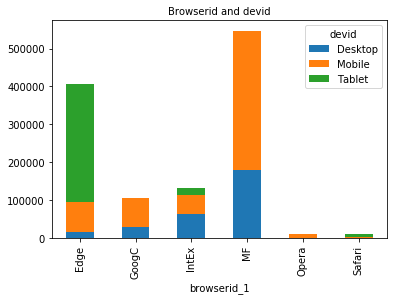

In [16]:
#understanding the relationships between different features since the target class is unbalanced
#browserid and devid;it is observed that Opera is displayed on only one device and Mobile is used for all browserids
bd=pd.crosstab(sample_df['browserid_1'],sample_df['devid'])
bd.plot(kind="bar",stacked=True)
plt.title('Browserid and devid', fontsize = 10)

Text(0.5, 1.0, 'Browserid and countrycode')

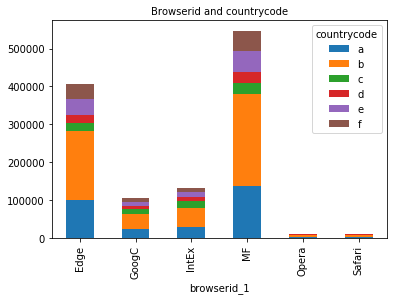

In [17]:
#Relationship between countrycode and browserid
bd=pd.crosstab(sample_df['browserid_1'],sample_df['countrycode'])
bd.plot(kind="bar",stacked=True)
plt.title('Browserid and countrycode', fontsize = 10)

Text(0.5, 1.0, 'Dependency of browserid with Target')

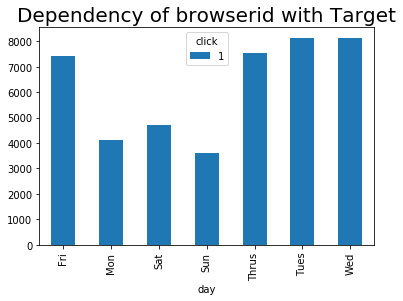

In [18]:
#checking no of clicks according to the days in the week keeping in mind that data contains tues wed thurs fri twice
dcl=pd.crosstab(sample_df['day'],sample_df[sample_df.click==1]['click'])
dcl.plot(kind="bar",stacked=True)
plt.title('Dependency of browserid with Target', fontsize = 20)

In [0]:
#Encoding categorical variables using mean encoding as class is unbalanced
sample_df['browserid_encode'] = sample_df['browserid_1'].map(sample_df.groupby('browserid_1')['click'].mean())
sample_df['devid_encode']=sample_df['devid'].map(sample_df.groupby('devid')['click'].mean())
sample_df['countrycode_encode']=sample_df['countrycode'].map(sample_df.groupby('countrycode')['click'].mean())
sample_df['day_encode']=sample_df['day'].map(sample_df.groupby('day')['click'].mean())

In [0]:
#Feature Engineering
#combining devid and browserid and encoding
sample_df['dev_bro']=sample_df['devid'].astype('str')+sample_df['browserid'].astype('str')
sample_df['dev_bro_encode']=sample_df['dev_bro'].map(sample_df.groupby('dev_bro')['click'].mean())
#combining site,offer,category,devid,browserid
sample_df['site_offer']=sample_df['siteid']+sample_df['offerid']
sample_df['offer_cat']=sample_df['offerid']+sample_df['category']
sample_df['site_offer_hour']=sample_df['site_offer']+sample_df['hour']
sample_df['site_offer_dev_bro']=sample_df['site_offer']+sample_df['dev_bro_encode']
sample_df['site_offer_day']=sample_df['site_offer']+sample_df['day_encode']

In [0]:
#splitting data into train and test
y=sample_df.click
X=sample_df.drop('click',axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [22]:
#checking feature importances
num_cols=list(X_train._get_numeric_data().columns)
fvalue_selector = SelectKBest(f_classif, k='all')
f_value=fvalue_selector.fit(X_train[num_cols],y_train)
feature=pd.DataFrame([num_cols,f_value.scores_,f_value.pvalues_])#columns:features,1st row:f_values,2nd row:p_values
feature

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,siteid,offerid,category,merchant,hour,browserid_encode,devid_encode,countrycode_encode,day_encode,dev_bro_encode,site_offer,offer_cat,site_offer_hour,site_offer_dev_bro,site_offer_day
1,0.0272441,4.35194,23.4816,319.999,2906.83,91864.5,12197.4,167162,312.55,151070,0.00136226,2.51316,0.0013674,0.0013629,0.00136227
2,0.868898,0.0369671,1.26135e-06,1.49398e-71,0,0,0,0,6.25489e-70,0,0.970558,0.1129,0.970502,0.970551,0.970558


In [23]:
#Listing the variables with significant p_values
list=['category', 'merchant','browserid_encode', 'devid_encode','countrycode_encode', 'day_encode', 'hour','dev_bro_encode']
#function for displaying various metrics
def params(yt,yp):
  print('Accuracy:',accuracy_score(yt,yp))
  print('F1score:',f1_score(yt,yp))
  print('Prec:',precision_score(yt,yp))
  print('Recall',recall_score(yt,yp))
  print('ROC:',roc_auc_score(yt,yp))
  print('-'*10)

X_train[list].head()

,category,merchant,browserid_encode,devid_encode,countrycode_encode,day_encode,hour,dev_bro_encode
7668472,3037,62689217,0.006046,0.067100,0.007446,0.039249,16,0.007053
9104856,72276,28017207,0.006046,0.067100,0.182963,0.030834,17,0.007053
2807256,40339,43452411,0.006046,0.038330,0.018674,0.041442,14,0.005000
11480474,45620,90174279,0.007528,0.005541,0.018061,0.041442,12,0.002710
9353226,53956,69514806,0.007528,0.005541,0.018674,0.041442,17,0.002710


In [26]:
#MinMax scaling required since category and merchants have large values
normalizer = MinMaxScaler()
num_columns = ['category', 'merchant']
normalizer.fit(X_train[num_columns])
X_train[num_columns] = normalizer.transform(X_train[num_columns])
X_test[num_columns] = normalizer.transform(X_test[num_columns])

X_train[list].head()

,category,merchant,browserid_encode,devid_encode,countrycode_encode,day_encode,hour,dev_bro_encode
7668472,0.029454,0.627362,0.006046,0.067100,0.007446,0.039249,16,0.007053
9104856,0.723113,0.278934,0.006046,0.067100,0.182963,0.030834,17,0.007053
2807256,0.403158,0.434047,0.006046,0.038330,0.018674,0.041442,14,0.005000
11480474,0.456065,0.903566,0.007528,0.005541,0.018061,0.041442,12,0.002710
9353226,0.539577,0.695954,0.007528,0.005541,0.018674,0.041442,17,0.002710


In [27]:
#Logistic Regression:Got good result for ROC_AUC score but precision goes for a toss
lr=LogisticRegression(class_weight='balanced')
lr.fit(X_train[list],y_train)
y_pred=lr.predict(X_test[list])
y_train_pred=lr.predict(X_train[list])
print('Testing params')
params(y_test,y_pred)
print('Training params')
params(y_train,y_train_pred)

Testing params
Accuracy: 0.8641492852925426
F1score: 0.32450294953026004
Prec: 0.19752963276977042
Recall 0.9084792415322273
ROC: 0.8854884813467617
----------
Training params
Accuracy: 0.8637879775812515
F1score: 0.3249337953079247
Prec: 0.19773393629180538
Recall 0.9109134316643228
ROC: 0.8864710748177902
----------


In [28]:
#Random Forest:Precision is still suffering
rfc=RandomForestClassifier(class_weight='balanced',max_depth=4,n_estimators=100)
rfc.fit(X_train[list],y_train)
y_pred_rf=rfc.predict(X_test[list])
y_train_pred_rf=rfc.predict(X_train[list])
print('Test')
params(y_test,y_pred_rf)
print('Train')
params(y_train,y_train_pred_rf)
print(classification_report(y_test,y_pred_rf))

Test
Accuracy: 0.884674639900037
F1score: 0.3596328036841624
Prec: 0.22461380216766033
Recall 0.9015979814970564
ROC: 0.8928210613013744
----------
Train
Accuracy: 0.8836280050750548
F1score: 0.3585418545357822
Prec: 0.22363309701854908
Recall 0.903718481211368
ROC: 0.8932982402504026
----------
              precision    recall  f1-score   support

           0       1.00      0.88      0.94    351056
           1       0.22      0.90      0.36     13079

   micro avg       0.88      0.88      0.88    364135
   macro avg       0.61      0.89      0.65    364135
weighted avg       0.97      0.88      0.92    364135



In [29]:
#Using Xgboost to improve precision
model = XGBClassifier()
model.fit(X_train[list], y_train)
y_pred_xg = model.predict(X_test[list])
y_train_xg = model.predict(X_train[list])
print('Test')
params(y_test,y_pred_xg)
print('Train')
params(y_train,y_train_xg)
print(classification_report(y_test,y_pred_xg))

Test
Accuracy: 0.9785134634132945
F1score: 0.6876646706586825
Prec: 0.7194887645142427
Recall 0.6585365853658537
ROC: 0.8244855799533339
----------
Train
Accuracy: 0.9784616181327283
F1score: 0.6883833395770188
Prec: 0.7180716899356994
Recall 0.6610524250253459
ROC: 0.8256816878145096
----------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    351056
           1       0.72      0.66      0.69     13079

   micro avg       0.98      0.98      0.98    364135
   macro avg       0.85      0.82      0.84    364135
weighted avg       0.98      0.98      0.98    364135

